In [1]:
import torch
from torch import nn
from torchvision.models import resnet18, vgg16, inception_v3, densenet161
import torchvision as tv
from torchvision.transforms import v2, transforms
from torchvision.datasets import EMNIST
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import time
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import kaggle
from collections import defaultdict
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f' Device: {torch.cuda.get_device_name(0)}. Now using: {device.type}', '\n',
      f'Torch Version: {torch.version.__version__}')

 Device: NVIDIA GeForce RTX 4070 Ti. Now using: cuda 
 Torch Version: 2.2.1


In [3]:
download = True
split = 'bymerge'

#Скачивается битый архив
try:
    train_dataset = EMNIST(split=split, download=True, root = os.getcwd())
except RuntimeError as e:
    print(e)


100%|██████████| 113789/113789 [00:01<00:00, 105749.47it/s]

File not found or corrupted.


In [ ]:
# destination = os.path.abspath(r'e:\python_projects\notebooks\Deep learning\Deep learning homeworks\EMNIST')
# ds_name = 'crawford/emnist'
# kaggle.api.dataset_download_files(ds_name, destination, unzip=True)

In [2]:
os.getcwd()

'e:\\python_projects\\notebooks\\Deep learning\\Deep learning homeworks'

In [2]:
class CSV_Dataset(Dataset):
    
    def __init__(self, csv_dataset, transform=None):

        self.data = pd.read_csv(csv_dataset, header=None)
        self.labels = self.data.iloc[:, 0].values
        self.images = self.data.iloc[:, 1:].values
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = self.images[idx].astype('float32').reshape(28, 28) /255
        label = self.labels[idx]
        assert 0 <= label < 62, "Label out of bounds"

        if self.transform:
            image = torch.tensor(image).unsqueeze(0)
            image = image.repeat(3, 1, 1) 
            image = self.transform(image)
        
        return image, torch.tensor(label)

train_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(degrees=25),
            transforms.Resize(256, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

test_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(256, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

In [3]:
#Функция из лекции 5. Добавил отчет по батчам

def train(
    model, 
    criterion,
    optimizer, 
    train_batch_gen,
    val_batch_gen,
    num_epochs=10,
    batch_log_interval=10
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True) 

        # на каждой "эпохе" делаем полный проход по данным
        for i, (X_batch, y_batch) in enumerate(train_batch_gen):
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            
            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)
            if (i + 1) % batch_log_interval == 0:
                print(f"Epoch {epoch + 1}, Batch {i + 1}: train_loss={train_loss / (i + 1):.6f}, train_acc={train_acc / (i + 1):.2f}, epoch total time: {time.time() - start_time:.2f}s", flush=True)


        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen) 
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
    
        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False) 

        # полностью проходим по валидационному датасету  
        for i, (X_batch, y_batch) in enumerate(val_batch_gen):
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

            # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen) 
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)
    
        # clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
        # plot_learning_curves(history)
        
    return model, history

In [4]:
# Датасет EMNIST-balanced для экономии времени

dir_path = 'e:\\python_projects\\notebooks\\Deep learning\\Deep learning homeworks\\EMNIST\\'
train_file_name = 'emnist-balanced-train.csv'
test_file_name = 'emnist-balanced-test.csv'

In [5]:
train_dataset = CSV_Dataset(dir_path+train_file_name, transform=train_transform)
test_dataset = CSV_Dataset(dir_path+test_file_name, transform=test_transform)

BATCH_SIZE = 128
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [7]:
temp_df = pd.read_csv(dir_path+train_file_name, header=None)

In [8]:
temp_df.iloc[:,0].nunique()

47

In [5]:
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

C:\Users\Big Brother\AppData\Local\Temp\ipykernel_18328\4217239964.py:4: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3641.)
  plt.imshow(sample.T, cmap = 'grey')
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


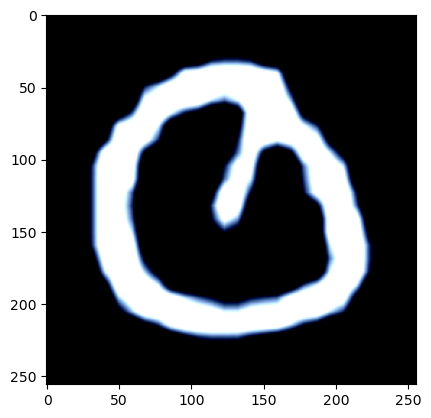

In [6]:
sample = images[np.random.randint(len(images))]
sample.shape

plt.imshow(sample.T, cmap = 'grey')

In [12]:
resnet = resnet18(weights=None)
resnet.fc = nn.Linear(512, 47)
# resnet.fc = nn.Sigmoid()
resnet = resnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=1e-5)

In [7]:
try:
    resnet(torch.randn(1, 3, 224, 224).to(device))
except RuntimeError as e:
    print(e)

In [ ]:
resnet_model, resnet_history = train(resnet, 
                           criterion, 
                           optimizer, 
                           train_dataloader, 
                           test_dataloader,
                           num_epochs=10,
                           batch_log_interval=100)

In [35]:
resnet_prog_loss = pd.DataFrame.from_dict(resnet_history['loss'], orient='columns')
resnet_prog_acc = pd.DataFrame.from_dict(resnet_history['acc'], orient='columns')

resnet_prog_loss.to_csv('resnet_loss.csv')
resnet_prog_acc.to_csv('resnet_acc.csv')


In [107]:
torch.cuda.empty_cache()

In [62]:
vgg = vgg16(weights=None)
vgg.fc = nn.Linear(512, 47)
vgg = vgg.to(device)

In [63]:
BATCH_SIZE = 32
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [67]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg.parameters(), lr=1e-4)

In [ ]:
vgg_model, vgg_history = train(vgg, 
                           criterion, 
                           optimizer, 
                           train_dataloader, 
                           test_dataloader,
                           num_epochs=10,
                           batch_log_interval=50)

In [69]:
vgg_prog_loss = pd.DataFrame.from_dict(vgg_history['loss'], orient='columns')
vgg_prog_acc = pd.DataFrame.from_dict(vgg_history['acc'], orient='columns')

vgg_prog_loss.to_csv('vgg_loss.csv')
vgg_prog_acc.to_csv('vgg_acc.csv')

In [5]:
train_transform_inc = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(degrees=25),
            transforms.Resize(299, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

test_transform_inc = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(299, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

In [119]:
torch.save(vgg_model.state_dict(), 'vgg_weights.pth')
torch.save(resnet_model.state_dict(), 'resnet_weights.pth')

In [124]:
import gc
# del vgg_model, resnet_model
del optimizer
torch.cuda.empty_cache()
gc.collect()

491

In [125]:
print(f"Allocated memory: {torch.cuda.memory_allocated()} bytes")
print(f"Reserved memory: {torch.cuda.memory_reserved()} bytes")

Allocated memory: 106901504 bytes
Reserved memory: 3107979264 bytes


In [6]:
train_dataset = CSV_Dataset(dir_path+train_file_name, transform=train_transform_inc)
test_dataset = CSV_Dataset(dir_path+test_file_name, transform=test_transform_inc)

BATCH_SIZE = 32
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [7]:
inception = inception_v3(weights=None, aux_logits=False)
inception.fc = nn.Linear(2048, 47)
inception = inception.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(inception.parameters(), lr=1e-4)

e:\Anaconda\Lib\site-packages\torchvision\models\inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [ ]:
try:
    inception(torch.randn(1, 3, 299, 299).to(device))
except RuntimeError as e:
    print(e)

In [ ]:
inception_model, inception_history = train(inception, 
                                     criterion, 
                                     optimizer, 
                                     train_dataloader, 
                                     test_dataloader,
                                     num_epochs=10,
                                     batch_log_interval=50)

In [10]:
torch.save(inception_model.state_dict(), 'inception_model.pth')

In [11]:
inception_prog_loss = pd.DataFrame.from_dict(inception_history['loss'], orient='columns')
inception_prog_acc = pd.DataFrame.from_dict(inception_history['acc'], orient='columns')

inception_prog_loss.to_csv('inception_loss.csv')
inception_prog_acc.to_csv('inception_acc.csv')

In [5]:
train_dataset = CSV_Dataset(dir_path+train_file_name, transform=train_transform)
test_dataset = CSV_Dataset(dir_path+test_file_name, transform=test_transform)

BATCH_SIZE = 16
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [6]:
densenet = densenet161(weights=None)
densenet.fc = nn.Linear(512, 47)
densenet = densenet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(densenet.parameters(), lr=1e-4)

In [12]:
try:
    densenet(torch.randn(1, 3, 224, 224).to(device))
except RuntimeError as e:
    print(e)

In [ ]:
densenet_model, densenet_history = train(densenet, 
                                     criterion, 
                                     optimizer, 
                                     train_dataloader, 
                                     test_dataloader,
                                     num_epochs=10,
                                     batch_log_interval=200)

In [14]:
torch.save(densenet_model.state_dict(), 'densenet_model.pth')

In [15]:
densenet_prog_loss = pd.DataFrame.from_dict(densenet_history['loss'], orient='columns')
densenet_prog_acc = pd.DataFrame.from_dict(densenet_history['acc'], orient='columns')

densenet_prog_loss.to_csv('densenet_loss.csv')
densenet_prog_acc.to_csv('densenet_acc.csv')

In [19]:
resnet_prog_acc = pd.read_csv('resnet_acc.csv')
vgg_prog_acc = pd.read_csv('vgg_acc.csv')
inception_prog_acc = pd.read_csv('inception_acc.csv')
densenet_prog_acc = pd.read_csv('densenet_acc.csv')

resnet_prog_loss = pd.read_csv('resnet_loss.csv')
vgg_prog_loss = pd.read_csv('vgg_loss.csv')
inception_prog_loss = pd.read_csv('inception_loss.csv')
densenet_prog_loss = pd.read_csv('densenet_loss.csv')

Не уверен, как должны вяглядеть итоговые таблицы, но пусть будет так:

In [103]:
fin_test_accuracy = pd.DataFrame()
fin_test_accuracy['Resnet'] = resnet_prog_acc['val']
fin_test_accuracy['Vgg'] = vgg_prog_acc['val']
fin_test_accuracy['Inception'] = inception_prog_acc['val']
fin_test_accuracy['Densenet'] = inception_prog_acc['val']

In [105]:
fin_test_loss = pd.DataFrame()
fin_test_loss['Resnet'] = resnet_prog_loss['val']
fin_test_loss['Vgg'] = vgg_prog_loss['val']
fin_test_loss['Inception'] = inception_prog_loss['val']
fin_test_loss['Densenet'] = inception_prog_loss['val']

In [106]:
fin_test_loss

,Resnet,Vgg,Inception,Densenet
0,0.927766,0.376833,0.377516,0.377516
1,0.581513,0.322755,0.350722,0.350722
2,0.461768,0.332025,0.309806,0.309806
3,0.409616,0.304273,0.303381,0.303381
4,0.380621,0.294545,0.293838,0.293838
5,0.359677,0.287020,0.292939,0.292939
6,0.347933,0.287499,0.293605,0.293605
7,0.336629,0.288918,0.289390,0.289390
8,0.327651,0.286510,0.284382,0.284382
9,0.328039,0.282983,0.290049,0.290049


In [104]:
fin_test_accuracy

,Resnet,Vgg,Inception,Densenet
0,0.789860,0.869951,0.864371,0.864371
1,0.835171,0.883185,0.875531,0.875531
2,0.857644,0.882228,0.888233,0.888233
3,0.869708,0.890253,0.893707,0.893707
4,0.874370,0.894186,0.894026,0.894026
5,0.879115,0.894186,0.892645,0.892645
6,0.882570,0.897959,0.895780,0.895780
7,0.883109,0.894983,0.898810,0.898810
8,0.883830,0.895568,0.894558,0.894558
9,0.885288,0.897375,0.898491,0.898491


На графиках гораздо нагляднее

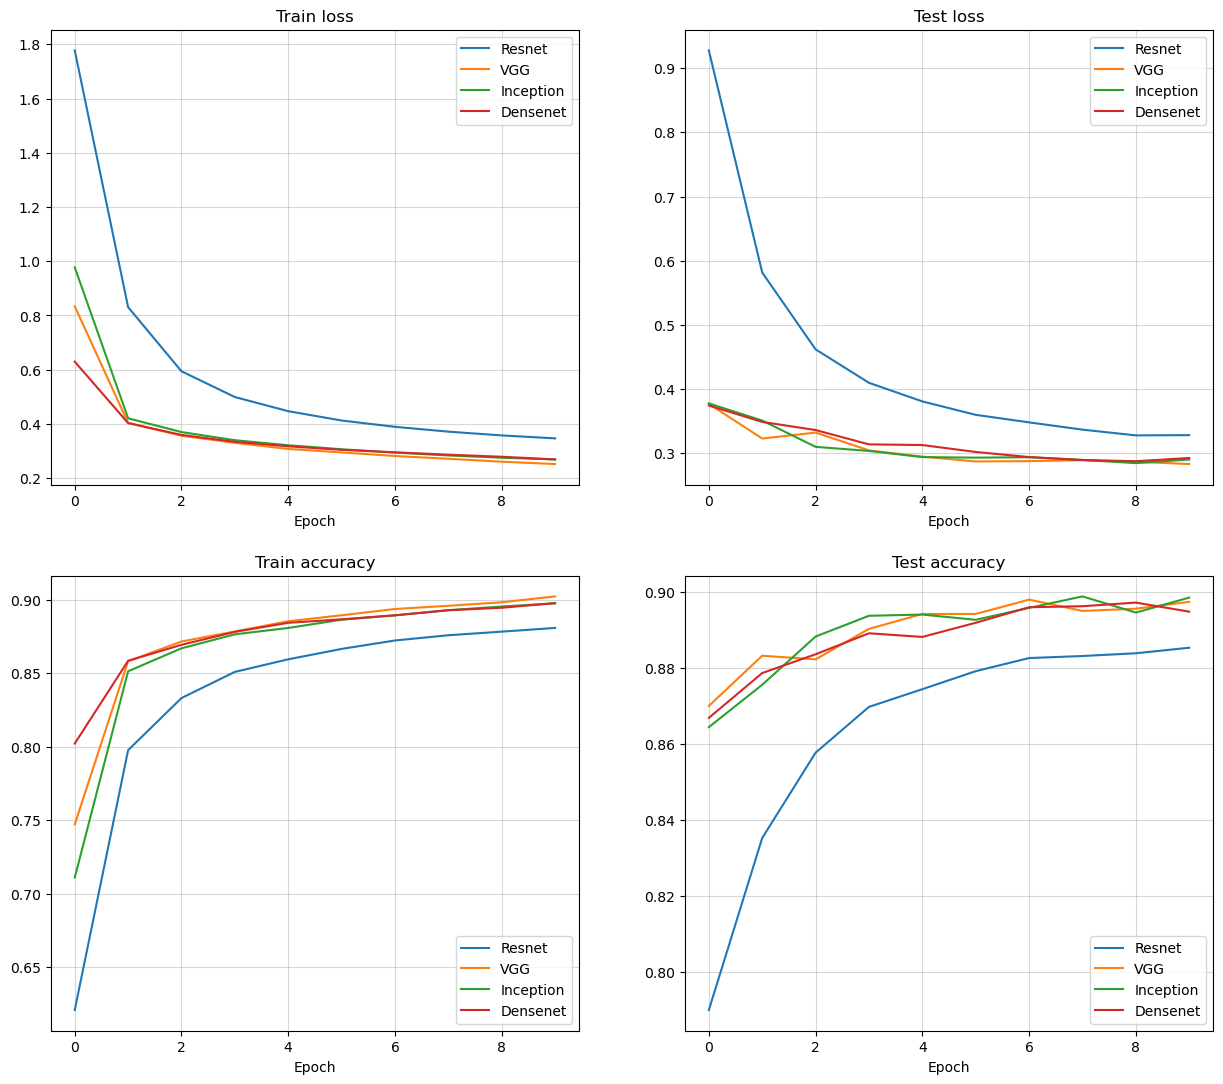

In [89]:
fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (15, 13), squeeze=True)
ax0, ax1, ax2, ax3 = axes.flatten()
for ax in axes.flatten():
    ax.grid(alpha=0.5)
    ax.set_xlabel('Epoch')

ax0.set_title('Train loss')
ax1.set_title('Test loss')
ax2.set_title('Train accuracy')
ax3.set_title('Test accuracy')

ax0.plot(resnet_prog_loss['train'], label = 'Resnet')
ax0.plot(vgg_prog_loss['train'], label = 'VGG')
ax0.plot(inception_prog_loss['train'], label = 'Inception')
ax0.plot(densenet_prog_loss['train'], label = 'Densenet')
ax0.legend()

ax1.plot(resnet_prog_loss['val'], label = 'Resnet')
ax1.plot(vgg_prog_loss['val'], label = 'VGG')
ax1.plot(inception_prog_loss['val'], label = 'Inception')
ax1.plot(densenet_prog_loss['val'], label = 'Densenet')
ax1.legend()

ax2.plot(resnet_prog_acc['train'], label = 'Resnet')
ax2.plot(vgg_prog_acc['train'], label = 'VGG')
ax2.plot(inception_prog_acc['train'], label = 'Inception')
ax2.plot(densenet_prog_acc['train'], label = 'Densenet')
ax2.legend()

ax3.plot(resnet_prog_acc['val'], label = 'Resnet')
ax3.plot(vgg_prog_acc['val'], label = 'VGG')
ax3.plot(inception_prog_acc['val'], label = 'Inception')
ax3.plot(densenet_prog_acc['val'], label = 'Densenet')
ax3.legend()